# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def save_data(x):
    x.to_csv('ready_data.csv', index=False)

# Data preparation

### Read Data and select columns for Model

In [3]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

#### If to drop all NAs from data frame then there will be an empty table. So some work is required per each column separately

In [4]:
#First I will use most commonsence properties that might influence the property Price
data = df[['status', 'private pool', 'baths',
           'homeFacts', 'fireplace', 'schools',
           'sqft', 'beds', 'state', 'stories',
           'PrivatePool', 'propertyType', 'target']]

### Property type

In [5]:
data.propertyType = data.propertyType.fillna('0')
data.propertyType = data.propertyType.str.lower()

In [6]:
data.propertyType[data.propertyType.str.contains('single')] = '1'
data.propertyType[data.propertyType.str.contains('condo')] = '2'
data.propertyType[data.propertyType.str.contains('land')] = '3'
data.propertyType[data.propertyType.str.contains('townhouse')] = '4'
data.propertyType[data.propertyType.str.contains('multi')] = '5'
data.propertyType[data.propertyType.str.contains('traditional')] = '6'
data.propertyType[data.propertyType.str.contains('coop')] = '7'
data.propertyType[data.propertyType.str.contains('\D')] = '8'

In [7]:
data.propertyType[data.propertyType.str.contains('\D')].value_counts(normalize=True)

Series([], Name: propertyType, dtype: float64)

In [8]:
data.propertyType.value_counts(normalize=True)

1    0.504917
2    0.135809
0    0.092085
3    0.083497
8    0.071180
4    0.049238
5    0.033175
6    0.020022
7    0.010077
Name: propertyType, dtype: float64

In [9]:
data.propertyType = data.propertyType.astype(int)

### Price of the Property (target) 

In [10]:
data.target.fillna(0, inplace=True)

In [11]:
data.target

0           $418,000
1           $310,000
2         $2,895,000
3         $2,395,000
4             $5,000
             ...    
377180    $1,249,000
377181      $674,999
377182      $528,000
377183       $34,500
377184      $204,900
Name: target, Length: 377185, dtype: object

In [12]:
#find symbols that are not numbers to replace
symbollist = data.target.str.findall(r'\D').value_counts().reset_index()['index']
s = list()
for i in symbollist:
    s = s + i
s = list(set(s))
s = ''.join(s)
print(f'Next symbols are to be replaced {s}')

Next symbols are to be replaced  ,/$m-+o


In [13]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x = x.replace('$', '').replace(',', '').replace('+', '').replace('/mo', '')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ') > 0:
        a = x.find(' - ')
        return((float(x[:a]) + float(x[a + 3:]))/2)  
    return(float(x))

In [14]:
data['target'] = data['target'].apply(clean_currency)
data = data.rename(columns={'target':'Price'})

In [15]:
data.Price = data.Price.astype(float)

In [16]:
print(f'There is {round(data.Price[data.Price == 0].count() / len(data.Price) * 100, 2)}% of missing values in Price')

There is 0.66% of missing values in Price


## Before dropping I will try to reduce the amount on NAs by other columns

## HomeFacts

In [17]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])

In [18]:
#Get Labels for df columns

def getdata(x):
    labels = list()
    for i in x:
        labels.append(i['factLabel'])
    return labels

labels = getdata(data.homeFacts[1])
labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [19]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in labels:
    data[l] = data['homeFacts'].apply(lambda x: x[labels.index(l)]['factValue']) 

In [20]:
save_data(data)

### Lotsize

In [21]:
data = pd.read_csv('ready_data.csv')

In [22]:
data.lotsize.iloc[10]

'1.73 acres'

In [23]:
# change strings to lower case and fill NAs and blanks with 0
data.lotsize = data.lotsize.str.lower().str.strip()
data.lotsize.fillna('0',inplace = True)

In [24]:
#create 2 lists of indexes , for values that contains "acre" and "sq" substrings
sq_index = data.lotsize[data.lotsize.str.contains('sq') == True].index
acre_index = data.lotsize[data.lotsize.str.contains('acre') == True].index

In [25]:
#Remove all literals from values that contain "sq"
data.lotsize.iloc[sq_index]=data.lotsize.iloc[sq_index].str.replace(r'\D','')

In [26]:
#Remove all literals from values that contain "acre" convert to float and convert to sqft
data.lotsize.iloc[acre_index] = round(data.lotsize.iloc[acre_index].str.replace('[a-z, ]','').astype(float) * 43560.04, 0)

In [27]:
#Take care of other literals too and blank values
other_index=data.lotsize[data.lotsize.str.contains('—|[a-z]') == True].index
data.lotsize.iloc[other_index] = '0'
other_index=data.lotsize[data.lotsize.str.contains(',') == True].index
data.lotsize.iloc[other_index] = data.lotsize.iloc[other_index].str.replace(',','')
data.lotsize[data.lotsize == ''] = 0

In [28]:
data.lotsize=data.lotsize.astype(float)

In [29]:
save_data(data)

## Price/sqft

In [30]:
data = pd.read_csv('ready_data.csv')

In [31]:
data['Price/sqft'] = data['Price/sqft'].str.lower()

In [32]:
#Get rid of strings near numbers
blank_list = ['$', '/sqft', ' / sq. ft.', ',']
for v in blank_list:
    data['Price/sqft'] = data['Price/sqft'].str.replace(v,'')

In [33]:
#Replace strings that mean no value to 0
zero_list = ['no data', 'no info', 'contact manager']
for v in zero_list:
    data['Price/sqft'] = data['Price/sqft'].str.replace(v,'0')    

In [34]:
data['Price/sqft'].fillna(0,inplace=True)

In [35]:
data['Price/sqft'] = data['Price/sqft'].astype(int)

## sqft

In [36]:
data.sqft=data.sqft.str.replace('\D','')

Before dropping Na's from sqft column I will retrieve information from Price/sqft, Price, lotsize, beds, baths

In [37]:
data.sqft = data.sqft.fillna(0)
data.sqft[data.sqft == ''] = 0
data.sqft = data.sqft.astype(float)
data.sqft[data.sqft < 0] = 0

In [38]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 14.12% of missing values in sqft


In [39]:
#use values from beds that points on area measurement data for filling 0 for sqft
values = data['beds'][(data.beds.str.contains('sqft') == True) & (data.sqft == 0)].str.replace('\D', '')
values.drop(labels = values[values == ''].index, inplace = True)
values=values.astype(float)
valuesA = data['beds'][(data.beds.str.contains('acres') == True) & (data.sqft == 0)]
valuesA = round(valuesA.str.replace('[a-z]', '').astype(float) * 43560.04, 2) 
data['sqft'].iloc[values.index] = values
data['sqft'].iloc[valuesA.index] = valuesA

In [40]:
data['beds'][data.beds.str.contains('sqft|arcres') == True] = 0

In [41]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 13.34% of missing values in sqft


In [42]:
#Fill NAs of sqft with values from lotsize
data.sqft[data.sqft == 0] = data.lotsize[data.sqft == 0]

In [43]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 3.26% of missing values in sqft


In [44]:
data1=data[['Price/sqft','sqft','Price']][(data.sqft == 0) & (data.Price != 0) & (data['Price/sqft'] != 0)]
print(f'There is {len(data1)} values Price/sqft and Price that can be used for sqft missing values')

There is 357 values Price/sqft and Price that can be used for sqft missing values


In [45]:
#replace missing values of sqft with [Price]/[Price/sqft]
data1.sqft = data1.Price / data1['Price/sqft']

In [46]:
data.sqft.iloc[data1.index] = data1.sqft

In [47]:
print(f'There is {round((data.sqft[data.sqft == 0].count()) / len(data.sqft) * 100, 2)}% of missing values in sqft')

There is 3.16% of missing values in sqft


Before taking the mean for missing values, I'll drop the exceptences

In [48]:
data.sqft.describe()

count    3.771850e+05
mean     3.994776e+04
std      5.032015e+06
min      0.000000e+00
25%      1.300000e+03
50%      1.939000e+03
75%      3.048000e+03
max      2.147484e+09
Name: sqft, dtype: float64

In [49]:
#sqft distribution
data.sqft.value_counts(normalize=True, bins=10)

(-2147483.648, 214748364.7]     0.999979
(214748364.7, 429496729.4]      0.000008
(429496729.4, 644245094.1]      0.000005
(1932735282.3, 2147483647.0]    0.000003
(1717986917.6, 1932735282.3]    0.000003
(644245094.1, 858993458.8]      0.000003
(1503238552.9, 1717986917.6]    0.000000
(1288490188.2, 1503238552.9]    0.000000
(1073741823.5, 1288490188.2]    0.000000
(858993458.8, 1073741823.5]     0.000000
Name: sqft, dtype: float64

In [50]:
data.drop(data.sqft[data.sqft > 214748364.7].index, inplace = True)

In [51]:
#Group data according to property type and take the average area for each property type for NA
area = data[['sqft','propertyType']][data.sqft != 0].groupby(by='propertyType').mean().reset_index()
area
area.sqft = area.sqft.round(decimals=0)
data.sqft[data.sqft == 0] = data[data.sqft == 0].merge(area, on='propertyType', how='left').sqft_y

In [52]:
data.sqft.fillna(0, inplace = True)

### Use sqft and Price/sqft to fill Price na's

In [53]:
#replace Price missing values with [sqft]*[Price/sqft]
data2 = data[['Price/sqft','sqft','Price']][(data.Price == 0) & (data.sqft != 0) & (data['Price/sqft'] != 0)]
data2.Price = data2.sqft * data2['Price/sqft']
data['Price'].iloc[data2.index] = data2.Price
print(f'There is {round(data.Price.isna().sum() / len(data.Price) * 100, 2)}% of missing values in Price')

There is 0.08% of missing values in Price


In [54]:
data.drop(['Price/sqft','lotsize'], axis=1, inplace=True)

### Replace the rest missing values in Price and sqft to mean and normalizing

In [55]:
data.Price[data.Price == 0] = data.Price[data.Price != 0].mean()
data.Price.fillna(data.Price[data.Price.isna() == False].mean(), inplace=True)
data.sqft[data.sqft == 0] = data.sqft[data.sqft != 0].mean()

In [56]:
#price distribution
data.Price.value_counts(normalize=True, bins=10)

(-194999.0, 19500000.9]       0.998624
(19500000.9, 39000000.8]      0.001053
(39000000.8, 58500000.7]      0.000209
(58500000.7, 78000000.6]      0.000074
(97500000.5, 117000000.4]     0.000013
(78000000.6, 97500000.5]      0.000013
(156000000.2, 175500000.1]    0.000005
(175500000.1, 195000000.0]    0.000003
(136500000.3, 156000000.2]    0.000003
(117000000.4, 136500000.3]    0.000003
Name: Price, dtype: float64

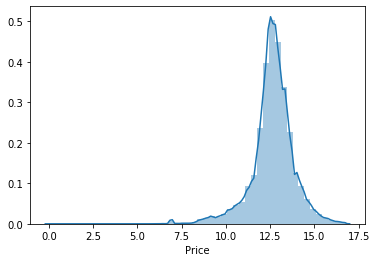

In [57]:
sns.distplot(np.log(data.Price[(data.Price > 0) & (data.Price <= 19500000.9)]))

In [58]:
#get rid of exceptions data
data.drop(data.Price[(data.Price <= 0) | (data.Price > 19500000.9)].index, axis=0 , inplace=True)

In [59]:
#normalizing Price
data.Price = np.log(data.Price)

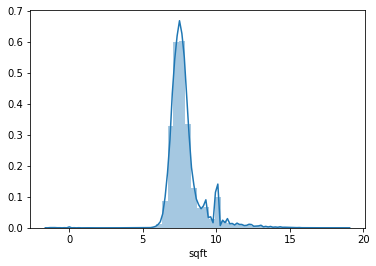

In [60]:
sns.distplot(np.log(data.sqft))

In [61]:
#normalizing sqft
data.sqft = np.log(data.sqft)

In [62]:
save_data(data)

## Schools

In [63]:
data = pd.read_csv('ready_data.csv')
data['schools'] = data['schools'].apply(lambda x: ast.literal_eval(x)[0])

In [64]:
#Extract rating list to school_rating column
data['school_rating'] = data['schools'].apply(lambda x: [n for n in x['rating'] if n != 'NR']) 

In [65]:
def find_rating(x):
    '''Function that makes an order in ratings and takes the maximum'''
    l = [0]
    for i in x:
        if (i.find('/') > -1 and i[:i.find('/')] == 'None') or i == 'NA' or i == '':
            l.append(0)
        elif i.find('/') > -1:
            l.append(int(i[:i.find('/')]))
        else:
            l.append(int(i))
    return max(l)

In [66]:
data['school_rating'] = data['school_rating'].apply(lambda x: find_rating(x))

In [67]:
save_data(data)

## Year built and remodeled

In [68]:
data = pd.read_csv('ready_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376658 entries, 0 to 376657
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          336780 non-null  object 
 1   private pool    4178 non-null    object 
 2   baths           270456 non-null  object 
 3   homeFacts       376658 non-null  object 
 4   fireplace       102920 non-null  object 
 5   schools         376658 non-null  object 
 6   sqft            376658 non-null  float64
 7   beds            285492 non-null  object 
 8   state           376658 non-null  object 
 9   stories         226226 non-null  object 
 10  PrivatePool     40104 non-null   object 
 11  propertyType    376658 non-null  int64  
 12  Price           376658 non-null  float64
 13  Year built      314388 non-null  object 
 14  Remodeled year  150906 non-null  float64
 15  Heating         267553 non-null  object 
 16  Cooling         252875 non-null  object 
 17  Parking   

In [69]:
#put indexes of str and num values in to variables
stri = data['Year built'][data['Year built'].str.contains('\D') == True].index
numi = data['Year built'][data['Year built'].str.contains('\D') == False].index

In [70]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp = data['Year built'].iloc[numi].astype('int64')
iyearexp = iyearexp[(data['Year built'].iloc[numi].astype('int64') < 0)
                    | (data['Year built'].iloc[numi].astype('int64') > 2020)].index
data['Year built'].iloc[iyearexp] = 'No Data'
numi=data['Year built'][data['Year built'].str.contains('\D') == False].index
stri=data['Year built'][data['Year built'].str.contains('\D') == True].index

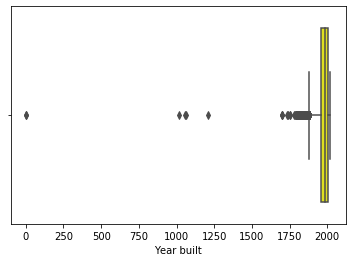

In [71]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color = 'yellow');

In [72]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')
iyearexp = iyearexp[(data['Year built'].iloc[numi].astype('int64') < 1500)
                    | (data['Year built'].iloc[numi].astype('int64') > 2020)].index
data['Year built'].iloc[iyearexp] = 'No Data'
numi=data['Year built'][data['Year built'].str.contains('\D') == False].index
stri=data['Year built'][data['Year built'].str.contains('\D') == True].index

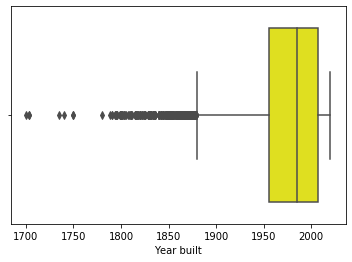

In [73]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [74]:
#convert numeric data to integer
data['Year built'].iloc[numi] = data['Year built'].iloc[numi].astype(int)

In [75]:
data['Year built'].iloc[numi].value_counts(normalize=True, bins=10)

(1988.0, 2020.0]      0.468478
(1956.0, 1988.0]      0.281294
(1924.0, 1956.0]      0.170183
(1892.0, 1924.0]      0.072140
(1860.0, 1892.0]      0.006742
(1828.0, 1860.0]      0.000837
(1796.0, 1828.0]      0.000271
(1764.0, 1796.0]      0.000032
(1732.0, 1764.0]      0.000013
(1699.679, 1732.0]    0.000010
Name: Year built, dtype: float64

In [76]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri] = int(round(data['Year built'].iloc[numi].mean(),0))

In [77]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)), inplace=True)

In [78]:
data['Year built'].describe()

count    376658.000000
mean       1979.204230
std          30.637637
min        1700.000000
25%        1963.000000
50%        1979.000000
75%        2005.000000
max        2020.000000
Name: Year built, dtype: float64

In [79]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(), inplace=True)
data['Remodeled year'] = data['Remodeled year'].astype(int)

### Status

In [80]:
data.status.value_counts(normalize=True)

for sale                  0.462860
Active                    0.312005
For sale                  0.128677
foreclosure               0.019081
New construction          0.016245
                            ...   
Coming soon: Nov 17.      0.000003
Coming soon: Nov 11.      0.000003
Under Contract W/ Bckp    0.000003
Sold: $285,000            0.000003
Pending Take Backups      0.000003
Name: status, Length: 159, dtype: float64

In [81]:
data.status[data.status.str.contains('for sale|active|accepted') == True] = 1

In [82]:
data.status[data.status != 1] = 0

In [83]:
data.status = data.status.astype(int)

### Private Pool

In [84]:
data['PrivatePool'] = data['PrivatePool'].str.lower()
data['private pool'] = data['private pool'].str.lower()

In [85]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']] = data[['private pool','PrivatePool']].replace(to_replace=['yes'],value = 1)
data['PrivatePool'] = data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool'] = data['PrivatePool'].fillna(0)
data = data.drop(['private pool'], axis=1)

In [86]:
data.PrivatePool = data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    332376
1     44282
Name: PrivatePool, dtype: int64

In [87]:
data.head()

,status,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,school_rating
0,0,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",7.972466,4,NC,NaN,0,1,12.943237,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,1,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",7.574045,3 Beds,WA,2.0,0,1,12.644328,2019,0,NaN,NaN,NaN,4
2,1,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",8.006368,3 Beds,CA,1.0,1,1,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,1,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",8.772920,5 Beds,TX,3.0,0,1,14.688894,2006,2006,Forced Air,Central,Detached Garage,10
4,1,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",9.212239,NaN,FL,NaN,0,3,8.517193,1979,0,NaN,NaN,NaN,5


### Bath

In [88]:
data.baths = data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum() / data.baths.count() * 100, 0)}% missing values')

There are 39.0% missing values


In [89]:
#Leave cells with numbers only for Bath 
data['baths'] = data.baths.str.findall(r'\d').str[0]

In [90]:
data['baths'][data.baths.isna() == False] = data['baths'][data.baths.isna() == False].astype(int)

In [91]:
data.baths.value_counts(normalize=True)

2.0    0.445732
3.0    0.270990
4.0    0.103669
1.0    0.096649
5.0    0.036931
6.0    0.016556
0.0    0.014567
7.0    0.008737
8.0    0.004276
9.0    0.001892
Name: baths, dtype: float64

In [92]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths = data[['baths','propertyType']]
Baths['baths'] = Baths['baths'][Baths.baths.isna() == False].astype(int)
Baths = Baths[Baths.baths.isna() == False].groupby(by='propertyType').mean().reset_index()
Baths.baths = Baths.baths.round(decimals=0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(Baths, on='propertyType', how='left').baths_y

In [93]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds = data[['baths','beds']]
BathsBeds['baths'] = BathsBeds['baths'][BathsBeds.baths.isna() == False].astype(int)
BathsBeds = BathsBeds[BathsBeds.baths.isna() == False].groupby(by='beds').mean().reset_index()
BathsBeds.baths = BathsBeds.baths.round(decimals = 0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376658 entries, 0 to 376657
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376658 non-null  int32  
 1   baths           299659 non-null  object 
 2   homeFacts       376658 non-null  object 
 3   fireplace       102920 non-null  object 
 4   schools         376658 non-null  object 
 5   sqft            376658 non-null  float64
 6   beds            285492 non-null  object 
 7   state           376658 non-null  object 
 8   stories         226226 non-null  object 
 9   PrivatePool     376658 non-null  int32  
 10  propertyType    376658 non-null  int64  
 11  Price           376658 non-null  float64
 12  Year built      376658 non-null  int64  
 13  Remodeled year  376658 non-null  int32  
 14  Heating         267553 non-null  object 
 15  Cooling         252875 non-null  object 
 16  Parking         201496 non-null  object 
 17  school_rat

In [94]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath')) & (data.beds.isna() == False)&(data.baths.isna() == True)]

107899    Baths
108413    Baths
108708    Baths
108772    Baths
109008    Baths
          ...  
375772    Baths
375934     Bath
375938    Baths
376106    Baths
376227     Bath
Name: beds, Length: 1057, dtype: object

In [95]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds == 'Bath') & (data.beds.isna() == False) & (data.baths.isna() == True)] = 1
data['beds'][(data.beds == 'Baths') & (data.beds.isna() == False) & (data.baths.isna() == True)] = 2
data['baths'][(data.beds.str.contains('Bath')) & (data.beds.isna() == False) & (data.baths.isna() == True)] = 1

In [96]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea = data[['baths','sqft']]
BathsArea['baths'] = BathsArea['baths'][BathsArea.baths.isna() == False].astype(int)
BathsArea = BathsArea[BathsArea.baths.isna() == False].groupby(by ='sqft').mean().reset_index()
BathsArea.baths = BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna() == True] = data[data.baths.isna() == True].merge(BathsArea, on='sqft', how='left').baths_y

In [97]:
data.baths.fillna(1, inplace=True)
data.baths = data.baths.astype(int)

### Beds

In [98]:
data.beds = data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 24.0% of missing values


In [99]:
data.beds.value_counts(normalize=True)

3 beds        0.187892
4 beds        0.124388
3             0.110403
2 beds        0.092666
4             0.070342
                ...   
4.73 acres    0.000004
4.21 acres    0.000004
1.51 acres    0.000004
1.39 acres    0.000004
7.8 acres     0.000004
Name: beds, Length: 589, dtype: float64

In [100]:
#leave numbers only for Beds
data['beds'] = data.beds.str.replace(' beds', '').str.replace(' bd', '')
data['beds'] = data.beds.str.replace('baths', '2')
data['beds'] = data.beds.str.replace('bath', '1')
data.beds[(data.beds.str.contains('\D') == True) & (data.beds.isna() == False)].value_counts(normalize=True)

3.0            0.379131
4.0            0.245207
2.0            0.113908
5.0            0.064314
--             0.047344
                 ...   
2.45 acres     0.000047
6.31 acres     0.000047
12.57 acres    0.000047
2.75 acres     0.000047
52 acres       0.000047
Name: beds, Length: 479, dtype: float64

In [101]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--') == True] = 0


In [102]:
data['beds'][data.beds.str.contains('2 bedrooms') == True] = 2
data['beds'][data.beds.str.contains('3 or more bedrooms') == True] = 3
data['beds'][data.beds.str.contains('based on redfin|-') == True] = 1

In [103]:
data['beds'] = data['beds'][(data.beds.isna() == False) & (data.beds != 'none')].astype(float)

In [104]:
#Group data according to property type and take the average area for each property type for NA
Beds = data[['beds', 'propertyType']]
Beds['beds'] = Beds['beds'][(Beds.beds.isna() == False)&(Beds.beds != 'none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds = Beds.beds.round(decimals=0)
data = data.merge(Beds, on='propertyType', how='left')

In [105]:
data['beds_x'].fillna(data.beds_y, inplace=True)
data['beds_x'][data.beds_x == 'none'] = data.beds_y
data.beds_x.fillna(data.beds_x.mean(), inplace=True)
data.drop('beds_y', axis = 1, inplace=True)
data = data.rename(columns = {'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376658 entries, 0 to 376657
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376658 non-null  int32  
 1   baths           376658 non-null  int32  
 2   homeFacts       376658 non-null  object 
 3   fireplace       102920 non-null  object 
 4   schools         376658 non-null  object 
 5   sqft            376658 non-null  float64
 6   beds            376658 non-null  float64
 7   state           376658 non-null  object 
 8   stories         226226 non-null  object 
 9   PrivatePool     376658 non-null  int32  
 10  propertyType    376658 non-null  int64  
 11  Price           376658 non-null  float64
 12  Year built      376658 non-null  int64  
 13  Remodeled year  376658 non-null  int32  
 14  Heating         267553 non-null  object 
 15  Cooling         252875 non-null  object 
 16  Parking         201496 non-null  object 
 17  school_rat

In [106]:
data.beds.value_counts(normalize=True, bins=10)

(-0.145, 14.4]    0.999116
(14.4, 28.8]      0.000637
(57.6, 72.0]      0.000117
(28.8, 43.2]      0.000090
(43.2, 57.6]      0.000029
(72.0, 86.4]      0.000005
(129.6, 144.0]    0.000003
(86.4, 100.8]     0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [107]:
data = data.drop(data.beds[data.beds > 15].index)

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376358 entries, 0 to 376657
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376358 non-null  int32  
 1   baths           376358 non-null  int32  
 2   homeFacts       376358 non-null  object 
 3   fireplace       102895 non-null  object 
 4   schools         376358 non-null  object 
 5   sqft            376358 non-null  float64
 6   beds            376358 non-null  float64
 7   state           376358 non-null  object 
 8   stories         226090 non-null  object 
 9   PrivatePool     376358 non-null  int32  
 10  propertyType    376358 non-null  int64  
 11  Price           376358 non-null  float64
 12  Year built      376358 non-null  int64  
 13  Remodeled year  376358 non-null  int32  
 14  Heating         267383 non-null  object 
 15  Cooling         252739 non-null  object 
 16  Parking         201335 non-null  object 
 17  school_rat

### Create feature baths per bedroom

In [109]:
data['baths'][data['baths'] < 1] = 1
data['beds'][data['beds'] < 1] = 1
data['baths/bed'] = data['beds'] / data['baths']

In [110]:
save_data(data)

### Fireplace

In [111]:
data = pd.read_csv('ready_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376358 entries, 0 to 376357
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376358 non-null  int64  
 1   baths           376358 non-null  int64  
 2   homeFacts       376358 non-null  object 
 3   fireplace       102895 non-null  object 
 4   schools         376358 non-null  object 
 5   sqft            376358 non-null  float64
 6   beds            376358 non-null  float64
 7   state           376358 non-null  object 
 8   stories         226090 non-null  object 
 9   PrivatePool     376358 non-null  int64  
 10  propertyType    376358 non-null  int64  
 11  Price           376358 non-null  float64
 12  Year built      376358 non-null  int64  
 13  Remodeled year  376358 non-null  int64  
 14  Heating         267383 non-null  object 
 15  Cooling         252739 non-null  object 
 16  Parking         201335 non-null  object 
 17  school_rat

In [112]:
data['fireplace'] = data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc') == True] = 1
data.fireplace[data.fireplace.str.contains('no|0 ') == True] = 0
data.fireplace[(data.fireplace.str.contains('\d') == True) & (data.fireplace.str.contains('0') == False)] = 1
data.fireplace[data.fireplace != 1] = 0

In [113]:
data.fireplace = data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376358 entries, 0 to 376357
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376358 non-null  int64  
 1   baths           376358 non-null  int64  
 2   homeFacts       376358 non-null  object 
 3   fireplace       376358 non-null  int32  
 4   schools         376358 non-null  object 
 5   sqft            376358 non-null  float64
 6   beds            376358 non-null  float64
 7   state           376358 non-null  object 
 8   stories         226090 non-null  object 
 9   PrivatePool     376358 non-null  int64  
 10  propertyType    376358 non-null  int64  
 11  Price           376358 non-null  float64
 12  Year built      376358 non-null  int64  
 13  Remodeled year  376358 non-null  int64  
 14  Heating         267383 non-null  object 
 15  Cooling         252739 non-null  object 
 16  Parking         201335 non-null  object 
 17  school_rat

### Stories

In [114]:
data.stories = data.stories.str.lower()

In [115]:
data['st1'] = data.stories.str.findall(r'\d').str[0]
data.stories[(data.st1.isna() == True)&(data.stories.isna() == False)].value_counts()

one                        5758
two                        2494
three or more               566
one story                   395
lot                         365
                           ... 
bedroom - split plan          1
two, three or more            1
multi level, tri level        1
other, two, multi/split       1
multi/split, two              1
Name: stories, Length: 96, dtype: int64

In [116]:
data.stories[data.stories.str.contains('one') == True] = 1
data.stories[data.stories.str.contains('two') == True] = 2

In [117]:
data.stories = data['st1'][(data.st1.isna() == False) & (data.stories.isna() == False)] 

In [118]:
data.drop('st1', axis=1, inplace=True)
data.dropna(subset=['stories'], axis=0, inplace=True)

In [119]:
data.stories = data.stories.astype(int)

In [120]:
data['stories'][data.stories < 2] = 1
data['stories'][data.stories > 1] = 2

In [121]:
data.stories.value_counts()

1    107631
2    106391
Name: stories, dtype: int64

In [122]:
save_data(data)

### Parking

In [123]:
data = pd.read_csv('ready_data.csv')
data.Parking.value_counts()

Attached Garage                                                 55674
2 spaces                                                        24478
1 space                                                         11409
No Data                                                          9708
Detached Garage                                                  8984
                                                                ...  
Assigned, Parking Space Conveys, Secure Parking, Parking Lot        1
Off street, On street, Open                                         1
On-site - Sale, Parking Fee, Attached Garage                        1
Brick Driveway, Attached Garage                                     1
Attached Garage, Garage - 3 Car, Keypad Entry                       1
Name: Parking, Length: 2786, dtype: int64

In [124]:
data.Parking[data.Parking.notnull() == True] = data.Parking[data.Parking.notnull() == True].str.lower()
data.Parking[(data.Parking.notnull() == True) & (data.Parking.str.contains('no') == True)] = 0
data.Parking[(data.Parking.notnull() == True)] = 1

In [125]:
data.Parking.fillna(0, inplace=True)
data.Parking.astype(int)

0         0
1         1
2         1
3         0
4         1
         ..
214017    1
214018    1
214019    1
214020    1
214021    1
Name: Parking, Length: 214022, dtype: int32

## Density per state- additional data

In [126]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [127]:
pd.read_html(url)[0].to_csv('density2010.csv', index=False)
density = pd.read_csv('density2010.csv')

In [128]:
density2010 = pd.DataFrame(density.iloc[3::4]['2010'].values, columns=['statefull'])
density2010['density'] = density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [129]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:, [0,3]].dropna().to_csv('abrv.csv', index=False)
stateabrv = pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [130]:
stateabrv.columns = ['statefull','state']

In [131]:
density2010 = density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [132]:
data.state = data.state.astype(str)

In [133]:
data.state

0         WA
1         CA
2         TX
3         PA
4         TX
          ..
214017    DC
214018    FL
214019    IL
214020    NY
214021    TX
Name: state, Length: 214022, dtype: object

In [134]:
data = data.merge(density2010, on='state', how='left')

In [135]:
data.density = data.density.astype(float)
data.density = data.density.fillna(data.density.mean())

In [136]:
save_data(data)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214022 entries, 0 to 214021
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          214022 non-null  int64  
 1   baths           214022 non-null  int64  
 2   homeFacts       214022 non-null  object 
 3   fireplace       214022 non-null  int64  
 4   schools         214022 non-null  object 
 5   sqft            214022 non-null  float64
 6   beds            214022 non-null  float64
 7   state           214022 non-null  object 
 8   stories         214022 non-null  int64  
 9   PrivatePool     214022 non-null  int64  
 10  propertyType    214022 non-null  int64  
 11  Price           214022 non-null  float64
 12  Year built      214022 non-null  int64  
 13  Remodeled year  214022 non-null  int64  
 14  Heating         184239 non-null  object 
 15  Cooling         174038 non-null  object 
 16  Parking         214022 non-null  int64  
 17  school_rat

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


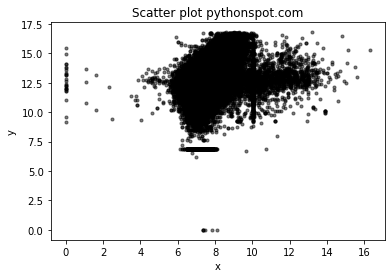

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
colors = (0,0,0)
area = np.pi*3

data = pd.read_csv('ready_data.csv')
plt.scatter(data.sqft, data.Price, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [16]:
data.Price.describe()

count    214022.000000
mean         12.746429
std           0.971194
min           0.000000
25%          12.254863
50%          12.706545
75%          13.251636
max          16.785925
Name: Price, dtype: float64